In [50]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import torch.optim as optim
from train import train_yolov2
import os
from model import model_builder
import lightnet as ln
import matplotlib.pyplot as plt
import numpy as np

In [3]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)



Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [35]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y["boxes"].to(device)
    
            # 1. Forward pass
            model_output = model(X)
            HBB_tensor = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.6,
                network_stride=model.stride,
                anchors=model.anchors
            )
            # 2. Calculate and accumulate loss
            loss = loss_fn(model_output.cpu(), y.cpu())
            test_loss += loss.item()
            
            
            # Calculate and accumulate accuracy
            # test_pred_labels = test_pred_logits.argmax(dim=1)
            # test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    # test_acc = test_acc / len(dataloader)
    return test_loss

In [36]:
test_step(
    model=model,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    device=DEVICE
)

1.8449365659914119

In [21]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [27]:
X, y = test_dataset[2]

In [46]:
model_output = model_2(X.unsqueeze(0))

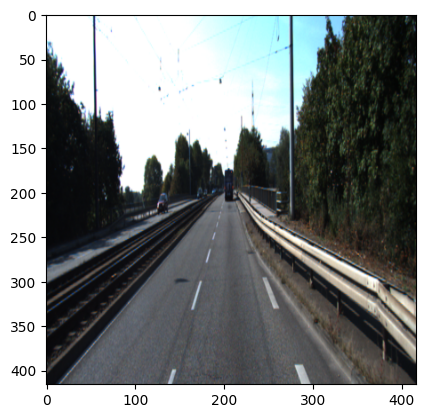

In [35]:
plt.imshow(X.permute(1, 2, 0))

In [19]:
y["boxes"]

tensor([[ 2.0000,  0.8263,  0.5688,  0.0759,  0.2057],
        [ 2.0000,  0.7364,  0.5140,  0.0399,  0.0813],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-

In [ ]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.6,
                network_stride=model.stride,
                anchors=model.anchors
            )

In [47]:
HBB_tensor = GetBoxes_fn(model_output)
HBB_tensor

tensor([[  0.0000, 132.7874, 216.0442,  18.3458,  26.2963,   0.6717,   2.0000]],
       grad_fn=<CatBackward0>)

In [54]:
bbox = HBB_tensor[:,1:5].detach().numpy()

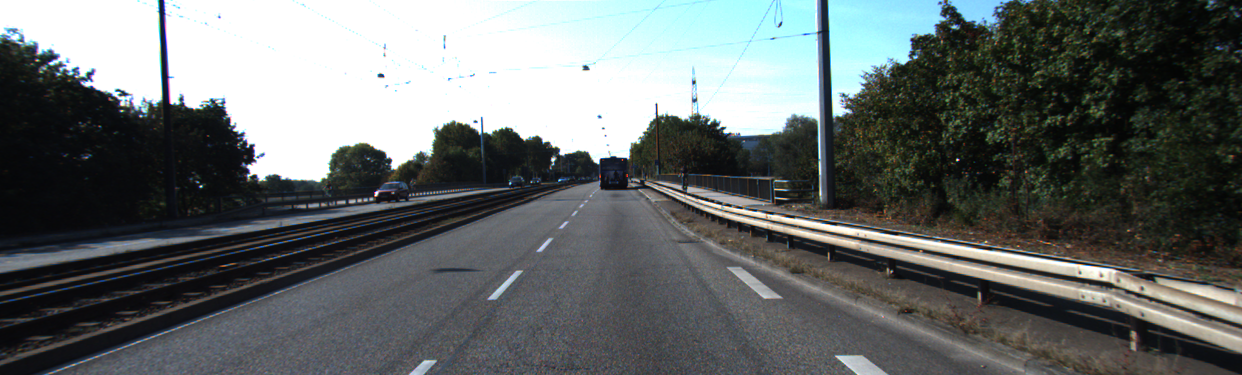

In [33]:
from PIL import Image, ImageDraw
img = Image.open("data/data_split/test/images/000023.png")
img

In [56]:
draw = ImageDraw.Draw(img)
draw.rectangle(bbox, outline="red", width=3)
img.show()

ValueError: x1 must be greater than or equal to x0